# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Convolutional-Neural-Networks" data-toc-modified-id="Convolutional-Neural-Networks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Convolutional Neural Networks</a></div><div class="lev2 toc-item"><a href="#Convolutional-layer" data-toc-modified-id="Convolutional-layer-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Convolutional layer</a></div><div class="lev3 toc-item"><a href="#Parameter-sharing" data-toc-modified-id="Parameter-sharing-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Parameter sharing</a></div><div class="lev2 toc-item"><a href="#Pooling" data-toc-modified-id="Pooling-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pooling</a></div><div class="lev1 toc-item"><a href="#Example:-MNIST" data-toc-modified-id="Example:-MNIST-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example: MNIST</a></div><div class="lev1 toc-item"><a href="#Retreat-to-a-higher-level" data-toc-modified-id="Retreat-to-a-higher-level-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Retreat to a higher level</a></div><div class="lev2 toc-item"><a href="#The-Model" data-toc-modified-id="The-Model-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The Model</a></div>

# Convolutional Neural Networks

This notebook makes extensive use of examples and figures from [here](http://cs231n.github.io/convolutional-networks/), which is a great reference for further details.

Recall the fully connected neural network.

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg",width=300>

As discussed last week, the fully connected neural network becomes cumbersome when we start considering image recognition; it needs *lots* of weights, and isn't designed to take advantage of spatial features in the inputs.  This is where CNNs become powerful.

<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg",width=300>

CNNs preserve the spatial (2-D) information of the input images, add a depth to their layers, and reduce the number of connections (and therefore weights).

The layers used to build CNN *architectures* fall into three categories:
 1. Convolutional Layer
 1. Pooling Layer
 1. Fully-Connected Layer

## Convolutional layer

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg",width=300>

Convolutional layers consist of a set of filters that apply over a small spatial area, but the full depth of the input.  The example above shows on the left a [32x32x3] input volume (width 32, height 32 image with RGB color channels).  The volume on the right is an example of a convolutional layer, with a particular **depth column** highlighted which takes as input *only* the highlighted region of the input volume.  The spatial extent of the area covered by a depth column is referred to as the **receptive field**.

The dimensions of the *output volume* are decided by 3 hyperparameters: **depth**, **stride**, and **zero-padding**.  We can compute the size of the output volume based on the volume size $W$, the receptive field size of the convolution layer $F$, their applied stride $S$, and the amount of zero padding used $P$.

Based on these parameters, the number of neurons in the convolution layer is $(W−F+2P)/S+1$. 

<img src="http://cs231n.github.io/assets/cnn/stride.jpeg">

Above is a 1-D example with inputs on the bottom in gray ($W=5$), and two different examples of a convolutional layer in yellow, both with receptive field $F=3$.

*Left*: This is a convolutional layer with stride $S = 1$, meaning we need ($5 - 3 + 2)/1+1 = 5$ neurons (i.e., outputs).

*Right*: Layer with stride $S = 2$, meaning an output of size $(5 - 3 + 2)/2+1 = 3$.

Note how on the left the zero padding allowed us to have the same number of outputs as inputs.  This is a common use of zero-padding.

### Parameter sharing

We can dramatically reduce the number of parameters involved in a convolutional layer by making the assumption that if one feature is useful to compute at some spatial position (x,y), then it should also be useful to compute at a different position (x2,y2).

In other words, denoting a single 2-dimensional slice of depth as a depth slice (e.g. a volume of size [7x7x3] has 3 depth slices, each of size [7x7]), we are going to constrain the neurons in each depth slice to use the same weights and bias. All $7\times7$ neurons in each depth slice will now be using the same parameters.

<img src="https://harishnarayanan.org/images/writing/artistic-style-transfer/conv-layer.gif">

## Pooling

Pooling layers act to reduce the dimension of the propagated volume, reducing the number of weights going forward, reducing cost and reducing the chances of over-fitting.  It operates independently on each depth slice.  A common operation is to take the MAX over a region.

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg", width=300>

For example,
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg", width=500>

**NOTE**: These are being used less these days.

# Example: MNIST

In [1]:
import os
import os.path
import shutil

import tensorflow as tf

/Users/bfarr/Virtualenvs/design_of_experiments/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let's return to the MNIST hand-written digits data set.  First we'll download some external images that will be useful for visualizations later.

In [2]:
!wget https://raw.githubusercontent.com/dandelionmane/tf-dev-summit-tensorboard-tutorial/master/labels_1024.tsv
!wget https://github.com/dandelionmane/tf-dev-summit-tensorboard-tutorial/raw/master/sprite_1024.png

--2018-03-23 08:30:19--  https://raw.githubusercontent.com/dandelionmane/tf-dev-summit-tensorboard-tutorial/master/labels_1024.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.188.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694 [text/plain]
Saving to: ‘labels_1024.tsv.3’

labels_1024.tsv.3   100%[===================>]     694  --.-KB/s    in 0s      

2018-03-23 08:30:20 (26.5 MB/s) - ‘labels_1024.tsv.3’ saved [2048]

--2018-03-23 08:30:20--  https://github.com/dandelionmane/tf-dev-summit-tensorboard-tutorial/raw/master/sprite_1024.png
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dandelionmane/tf-dev-summit-tensorboard-tutorial/master/sprite_1024.png [fol

In [3]:
logdir = "/tmp/mnist_example/"
labels = os.path.join(os.getcwd(), "labels_1024.tsv")
sprites = os.path.join(os.getcwd(), "sprite_1024.png")

In [4]:
mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir=logdir + "data", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/mnist_example/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/mnist_example/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/mnist_example/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/mnist_example/data/t10k-labels-idx1-ubyte.gz


First let's define our layer functions for later use.

In [5]:
def conv_layer(input, size_in, size_out, name="conv"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
        act = tf.nn.relu(conv + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    
def fc_layer(input, size_in, size_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        act = tf.matmul(input, w) + b
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

Now we'll build the model.

In [1]:
def mnist_model(learning_rate, use_two_fc, use_two_conv, hparam):
    tf.reset_default_graph()
    sess = tf.Session()

    # Setup placeholders, and reshape the data
    x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    tf.summary.image('input', x_image, 3)
    y = tf.placeholder(tf.float32, shape=[None, 10], name="labels")

    if use_two_conv:
        conv1 = conv_layer(x_image, 1, 32, "conv1")
        conv_out = conv_layer(conv1, 32, 64, "conv2")
    else:
        conv_out = conv_layer(x_image, 1, 16, "conv")

    flattened = tf.reshape(conv_out, [-1, 7 * 7 * 64])

    if use_two_fc:
        fc1 = fc_layer(flattened, 7 * 7 * 64, 1024, "fc1")
        relu = tf.nn.relu(fc1)
        embedding_input = relu
        tf.summary.histogram("fc1/relu", relu)
        embedding_size = 1024
        logits = fc_layer(fc1, 1024, 10, "fc2")
    else:
        embedding_input = flattened
        embedding_size = 7*7*64
        logits = fc_layer(flattened, 7*7*64, 10, "fc")

    with tf.name_scope("xent"):
        xent = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=y), name="xent")
        tf.summary.scalar("xent", xent)

    with tf.name_scope("train"):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(xent)

    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar("accuracy", accuracy)

    summ = tf.summary.merge_all()


    embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="test_embedding")
    assignment = embedding.assign(embedding_input)
    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(logdir + hparam)
    writer.add_graph(sess.graph)

    config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
    embedding_config = config.embeddings.add()
    embedding_config.tensor_name = embedding.name
    embedding_config.sprite.image_path = sprites
    embedding_config.metadata_path = labels
    # Specify the width and height of a single thumbnail.
    embedding_config.sprite.single_image_dim.extend([28, 28])
    tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

    for i in range(2001):
        batch = mnist.train.next_batch(100)
        if i % 5 == 0:
            [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: batch[0], y: batch[1]})
            writer.add_summary(s, i)
        if i % 500 == 0:
            sess.run(assignment, feed_dict={x: mnist.test.images[:1024], y: mnist.test.labels[:1024]})
            saver.save(sess, os.path.join(logdir, "model.ckpt"), i)
        sess.run(train_step, feed_dict={x: batch[0], y: batch[1]})

def make_hparam_string(learning_rate, use_two_fc, use_two_conv):
    conv_param = "conv=2" if use_two_conv else "conv=1"
    fc_param = "fc=2" if use_two_fc else "fc=1"
    return "lr_%.0E,%s,%s" % (learning_rate, conv_param, fc_param)

In [7]:
# You can try adding some more learning rates
learning_rate =  1E-3

# Include "False" as a value to try different model architectures
use_two_fc = False
use_two_conv = False

# Construct a hyperparameter string for each one (example: "lr_1E-3,fc=2,conv=2")
hparam = make_hparam_string(learning_rate, use_two_fc, use_two_conv)
print('Starting run for %s' % hparam)

# Actually run with the new settings
mnist_model(learning_rate, use_two_fc, use_two_conv, hparam)
print('Done training!')
print('Run `tensorboard --logdir=%s` to see the results.' % logdir)

Starting run for lr_1E-03,conv=1,fc=1
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



KeyboardInterrupt: 

In [8]:
# You can try adding some more learning rates
learning_rate = 1E-3

# Include "False" as a value to try different model architectures
use_two_fc = True
use_two_conv = True

# Construct a hyperparameter string for each one (example: "lr_1E-3,fc=2,conv=2")
hparam = make_hparam_string(learning_rate, use_two_fc, use_two_conv)
print('Starting run for %s' % hparam)

# Actually run with the new settings
mnist_model(learning_rate, use_two_fc, use_two_conv, hparam)
print('Done training!')
print('Run `tensorboard --logdir=%s` to see the results.' % logdir)

Starting run for lr_1E-03,conv=2,fc=2
Done training!
Run `tensorboard --logdir=/tmp/mnist_example/` to see the results.


# Retreat to a higher level

`TensorFlow` is an *incredibly* powerful tool, but it can be cumbersom to work with.  [keras](https://keras.io/) is a higher-level neural network API that uses `TensorFlow` (amond other things) under the hood, but allows you to networks wtih a lot less stress.

In [17]:
!pip install keras

    100% |████████████████████████████████| 327kB 3.4MB/s ta 0:00:01
    100% |████████████████████████████████| 256kB 4.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /Users/bfarr/Library/Caches/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml


In [24]:
import keras

from matplotlib import pyplot as plt

We'll start off working with our favorit MNIST handwritten digit data set.

In [53]:
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)

(60000, 28, 28)


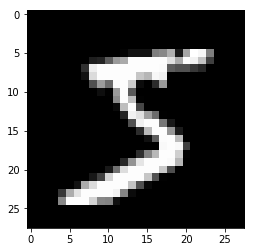

In [54]:
plt.imshow(X_train[0], cmap='gray')

In [55]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [56]:
print(X_train.dtype, X_train.max())

uint8 255


Notice that the pixel values imported as an integer array that saturates at `255`.  Let's turn the data into floats $\in [0, 1]$.

In [57]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [58]:
print(y_train.shape)
print(y_train[:10])

(60000,)
[5 0 4 1 9 2 1 3 1 4]


The results are stored as labels, but we'll want to work with a one-hot representation.  `keras` has a utility to make this conversion easy.

In [68]:
Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)

In [69]:
print(Y_train.shape)
print(Y_train[:10])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## The Model

We'll now build our model.  We're building what `keras` refers to as a *sequential* model, i.e., we'll be building a simple stack of neural network layers.

In [61]:
model = keras.models.Sequential()

Our first layer (after the input layer) will be a convolutional layer with `32` filters.  As the first layer, we need to tell it what input shape to expect (later layers will automatically determine this from the last layer that was added).

In [ ]:
model.add(keras.layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

Just to demonstrate what's going on under the hood, we can print the current output shape of the model, which is the information that's fed into layers as we add them on.

In [62]:
print(model.output_shape)

(None, 26, 26, 32)


Now let's add on another `32`-filter convolutional layer, following by a 2-D pooling layer with a pooling size of `2x2`.

In [63]:
model.add(keras.layers.Convolution2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

Next we'll add on a *dropout* layer.  This layer will set the specified fraction of inputs to `0`, which can be useful for avoiding over fitting.  We'll drop $25\%$ of the inputs with this layer.   

In [ ]:
model.add(keras.layers.Dropout(0.25))

Next we'll add a fully connected layer with `128` nodes, making sure to flatten the volume before passing to this layer.

In [64]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))

We'll now add one final $25\%$ dropout layer for good measure, followed by the output layer.

In [ ]:
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))

Now that we've built our full model it's time to compile it, specifying the loss function, optimizer, and any metrics we want to look at, and fit on the training data.

In [65]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [67]:
model.fit(X_train, Y_train, 
          batch_size=32, epochs=10, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 38s 626us/step - loss: 0.1010 - acc: 0.9694
Epoch 2/10
60000/60000 [==============================] - 38s 626us/step - loss: 0.0735 - acc: 0.9778
Epoch 3/10
60000/60000 [==============================] - 38s 629us/step - loss: 0.0596 - acc: 0.9818
Epoch 4/10
60000/60000 [==============================] - 38s 633us/step - loss: 0.0501 - acc: 0.9849
Epoch 5/10
60000/60000 [==============================] - 38s 631us/step - loss: 0.0414 - acc: 0.9872
Epoch 6/10
60000/60000 [==============================] - 38s 636us/step - loss: 0.0373 - acc: 0.9886
Epoch 7/10
60000/60000 [==============================] - 38s 632us/step - loss: 0.0344 - acc: 0.9892
Epoch 8/10
60000/60000 [==============================] - 38s 632us/step - loss: 0.0308 - acc: 0.9903
Epoch 9/10
60000/60000 [==============================] - 38s 630us/step - loss: 0.0284 - acc: 0.9912
Epoch 10/10
60000/60000 [==============================] - 37s 624us/step - loss: 

In [73]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("loss: {}, accuracy: {}".format(*score))

loss: 0.029538341434300355, accuracy: 0.9915
